# DAND - Project 2 - Data Analysis

This project will conduct a Data Analysis on the Titanic passengers' data

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
# Set seaborn plots
sns.set(style="whitegrid", context="talk")
sns.set_context(rc={"figure.figsize": (8, 4)})

# load the data
passengers_df = pd.read_csv("titanic_data.csv")

passengers_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S


We are interested in several questions:
* Average survival rate and distribution in ages
* The survival rate of children (age 18 and under), adult males, adult females
* Survival rate by socio-economic status (Pclass)
* Does having Sibling or Spouse on the ship inrease/decrease survivability (SibSp > 0 or Parch > 0)
* Are there any tendencies for Port of Embarkation - e.g. people or children concentration

In [3]:
print "Rows count:"
passengers_df.count()

Rows count:


PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [4]:
survival_mean = passengers_df["Survived"].mean()
print "Survived {} out of {}".format(passengers_df["Survived"].sum(), passengers_df["Survived"].count())
print "Average probability of survival: {}".format(round(survival_mean, 2))

Survived 342 out of 891
Average probability of survival: 0.38


In [5]:
# separate survivors and non survivors
survivors = passengers_df[passengers_df["Survived"] > 0]
non_survivors = passengers_df[passengers_df["Survived"] == 0]

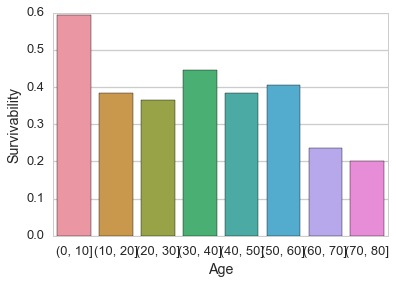

In [6]:
%matplotlib inline
# take all the passengers with 'Age' value
df_with_ages = passengers_df[pd.notnull(passengers_df['Age'])]

# group them by 10 years 
group_by_age = df_with_ages.groupby(
    pd.cut(df_with_ages['Age'], np.arange(0, 90, 10), include_lowest=False)
)

# Visualize age groups survivability
ax = sns.barplot(data=pd.DataFrame(group_by_age['Survived'].mean()).T)
ax.set_ylabel("Survivability")

In [7]:
# get datasets with children, males, females
children = df_with_ages[(df_with_ages['Age'] <= 18)]
adult_males = df_with_ages[(df_with_ages['Age'] > 18) & (df_with_ages['Sex'] == 'male')]
adult_females = df_with_ages[(df_with_ages['Age'] > 18) & (df_with_ages['Sex'] == 'female')]

# Combine the mean data into a dataframe
surv_data = pd.DataFrame([
        [children['Survived'].mean(),adult_males['Survived'].mean(), adult_females['Survived'].mean()]
    ], index=["Survivability"], columns=["Children", "Adult males", "Adult females"]).round(2)
surv_data

,Children,Adult males,Adult females
Survivability,0.5,0.18,0.78


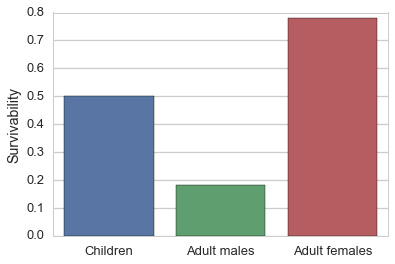

In [8]:
# Visualize the survivability mean
ax = sns.barplot(data=surv_data)
ax.set_ylabel("Survivability")

In [9]:
# Group passengers by Pclass and calculate the mean of survivability for each Pclass
class_surv_data = pd.DataFrame(passengers_df.groupby('Pclass')['Survived'].mean()).T
class_surv_data

Pclass,1,2,3
Survived,0.62963,0.472826,0.242363


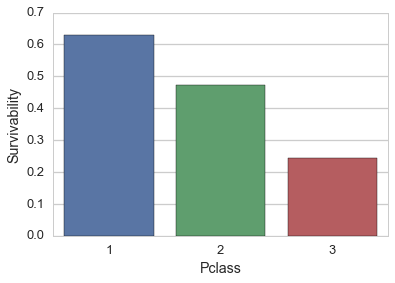

In [10]:
ax = sns.barplot(data=class_surv_data)
ax.set_ylabel("Survivability")

## Here we'll test if the chance of surviving between those who have relatives and those who don't is statistically significant at α = 0.01

In [11]:
print u'H\u2080: \u039Chr = \u039cnhr          H\u2081: \u039Chr \u2260 \u039cnhr          \u03B1 = .01'

H₀: Μhr = Μnhr          H₁: Μhr ≠ Μnhr          α = .01


In [12]:
# separate those having relatives (hr) from those who don't (nhr)
having_relatives = passengers_df[(passengers_df['SibSp'] > 0) | (passengers_df['Parch'] > 0)]['Survived']
not_having_relatives = passengers_df[(passengers_df['SibSp'] == 0) & (passengers_df['Parch'] == 0)]['Survived']

print having_relatives.describe()
print not_having_relatives.describe()

count    354.000000
mean       0.505650
std        0.500676
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64
count    537.000000
mean       0.303538
std        0.460214
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


In [13]:
## Get the means
hr_xbar = having_relatives.mean()
nhr_xbar = not_having_relatives.mean()

# Calculate Sum of Squares for samples
ss_hr = np.sum((having_relatives - hr_xbar) ** 2)
ss_nhr = np.sum((not_having_relatives - nhr_xbar) ** 2)

# Degree of Freedom
dof = having_relatives.count() + not_having_relatives.count() - 2
print "Degree of freedom: {}".format(dof)
# Pooled Variance
pooled_var = (ss_hr + ss_nhr)/dof

# Standared Error
st_err = math.sqrt(pooled_var/having_relatives.count() + pooled_var/not_having_relatives.count())

# t-statistic
t_statistic = (hr_xbar - nhr_xbar)/st_err
print "t-statistic: {}".format(round(t_statistic,2))

# t-critical 
t_critical = 2.581
print "t-critical: {}".format(t_critical)

# Margin of Error
margin_of_error = t_critical * st_err

Degree of freedom: 889
t-statistic: 6.19
t-critical: 2.581


** The two-tailed P value is less than 0.0001 **  
** By conventional criteria, this difference is considered to be extremely statistically significant. **  
** *Based on the result Μhr ≠ Μnhr and we can reject the null hypotheses. * **

In [14]:
CI_left = hr_xbar - nhr_xbar - margin_of_error
CI_right = hr_xbar - nhr_xbar + margin_of_error
print "CI(99%) = ({}, {})".format(CI_left, CI_right)

CI(99%) = (0.117879804282, 0.286343280653)


** *We are 99% sure that people who have relatives on criuses have between 12% and 29% higher chance of surviving in case of a shipwreck* **

In [15]:
# Another way of computing the t-statistic and p-value would be this one 
# but I did the above because of the confidence intervals
t, p = ttest_ind(having_relatives, not_having_relatives)
"t-statistic: {}, p-value: {}".format(t,p)

't-statistic: 6.19303248808, p-value: 9.00949017933e-10'

Sources:
  1. [Titanic passengers' data and description](https://www.kaggle.com/c/titanic/data)